# Keras MLP -> best Log Loss 0.555
## Overview ##
This kernel uses seeding and relative seeding with an MLP network. Spread on loss was very small, so kfold not necessary

In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from time import localtime
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping, TensorBoard, ProgbarLogger
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold




# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../NCAA"]).decode("utf8"))

# Any results you write to the current directory are saved as output.


Data
GiantKillerInfo.txt
KaggleKernelwSeeds.ipynb
KerasBinaryClassifier_Intro.ipynb
KerasMLP_only2003.csv
KerasMLP_onlyBPI_2009-2013.csv
KerasMLP_onlyseed.csv
KerasMLP_onlyseeds.csv
KerasMLP_RankAndSeeds.ipynb
KerasMLP_Rank_Kfold.ipynb
KerasMLP_RankSeedsYear_1_2.csv
KerasMLP_RankSeedsYear_1.csv
KerasMLP_RankSeedsYear.csv
KerasMLP_RanksKfold.ipynb
KerasMLP_SeedsandYear_1.csv
KerasMLP_SeedsandYear.csv
KerasMLP_SeedsOnly.ipynb
KerasMLP_SeedswithTB.ipynb
logreg_withseedtoo.csv
logs
MasseyOrdinalsExp.ipynb
MLP_first_go.csv
MLP_with_seeds.csv
sonar.csv
SVM_first_go.csv
Tensorflow.ipynb



### Lock Random Seed

In [2]:
seed = 13
np.random.seed(seed)

### Load Training data


In [3]:
data_dir = '../NCAA/Data/'
df_seeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


Incorporate Massey Ordinals - MAS, SAG, POM

In [4]:
#Load Data
df_rank = pd.read_csv(data_dir+ 'MasseyOrdinals.csv')
#Choose Latest Ranking 
df_rank = df_rank[df_rank.RankingDayNum>=133]
df_rank = df_rank[df_rank.Season>=2010]

#Selectr rankings of interest and make each ranking system ranking into a separate column
df_merge = pd.merge(df_rank.loc[df_rank['SystemName']=='MAS'],
                    df_rank.loc[df_rank['SystemName']=='SAG'], how='left', 
                    on=['Season', 'TeamID', 'RankingDayNum'])
df_rank = pd.merge(left=df_merge, right=df_rank.loc[df_rank['SystemName']=='POM'], 
                  how='left', on=['Season', 'TeamID', 'RankingDayNum'] )

In [5]:
# Drop
df_rank.drop(labels=['SystemName_x', 'SystemName_y', 'SystemName','RankingDayNum'], inplace=True, axis =1)
df_rank.rename(columns={'OrdinalRank_x':'MAS', 'OrdinalRank_y':'SAG', 'OrdinalRank':'POM'}, inplace=True)

df_rank.head()

,Season,TeamID,MAS,SAG,POM
0,2010,1102,239,237,246
1,2010,1103,89,105,119
2,2010,1104,79,72,64
3,2010,1105,329,337,336
4,2010,1106,276,300,302


Cut seasons prior to Max Ranking date

In [6]:
df_seeds = df_seeds[df_seeds.Season>=min(df_rank.Season) ]
df_seeds = df_seeds[ df_seeds.Season<=max(df_rank.Season)]
df_tour = df_tour[df_tour.Season>=min(df_rank.Season)]
df_tour = df_tour[ df_tour.Season<=max(df_rank.Season)]
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1584,2010,134,1115,61,1457,44,N,0
1585,2010,136,1124,68,1358,59,N,0
1586,2010,136,1139,77,1431,59,N,0
1587,2010,136,1140,99,1196,92,N,2
1588,2010,136,1242,90,1250,74,N,0


Cut off the region identifier from the seed number

In [7]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(columns=['Seed'], inplace=True) # This is the string label

In [8]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore','WLoc', 'NumOT'], inplace=True, axis=1)
# df_tour.head()

Merge the Seeds with their corresponding TeamIDs in the compact results dataframe.

In [9]:
df_winSeeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossSeeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_seeds.head()

,Season,TeamID,seed_int
1609,2010,1246,1
1610,2010,1452,2
1611,2010,1307,3
1612,2010,1458,4
1613,2010,1396,5


In [10]:
df_dummy = pd.merge(left=df_tour, right=df_lossSeeds, how='left', on=['Season', 'LTeamID'])
df_dummy.head()

,Season,WTeamID,LTeamID,LSeed
0,2010,1115,1457,16
1,2010,1124,1358,14
2,2010,1139,1431,12
3,2010,1140,1196,10
4,2010,1242,1250,16


In [11]:
df_concat = pd.merge(left=df_dummy, right=df_winSeeds, how='left' ,on=['Season', 'WTeamID'])
# df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,LSeed,WSeed
0,2010,1115,1457,16,16
1,2010,1124,1358,14,3
2,2010,1139,1431,12,5
3,2010,1140,1196,10,7
4,2010,1242,1250,16,1


Dataframe with seed, relative seed, and win/loss. Use for training

In [12]:
df_wins = pd.DataFrame()
df_wins['Seed'] = df_concat['WSeed']
# df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['TeamID'] = df_concat['WTeamID']
df_wins['Season'] = df_concat['Season']
df_wins['Result'] = 1
df_wins = pd.merge(left=df_wins, right=df_rank, how='left', on=['Season', 'TeamID'])
df_wins.head()
df_wins.head()

,Seed,TeamID,Season,Result,MAS,SAG,POM
0,16,1115,2010,1,232,239,238
1,3,1124,2010,1,11,8,12
2,5,1139,2010,1,13,22,26
3,7,1140,2010,1,14,9,7
4,1,1242,2010,1,1,1,2


In [13]:
df_losses = pd.DataFrame()
df_losses['Seed'] = df_concat['LSeed']
# df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['TeamID'] = df_concat['LTeamID']
df_losses['Season'] = df_concat['Season']
df_losses['Result'] = 0
df_losses = pd.merge(left=df_losses, right=df_rank, how='left',on=['Season', 'TeamID'])
df_losses.head()

,Seed,TeamID,Season,Result,MAS,SAG,POM
0,16,1457,2010,0,192,210,212
1,14,1358,2010,0,96,106,102
2,12,1431,2010,0,28,33,34
3,10,1196,2010,0,55,48,49
4,16,1250,2010,0,201,204,180


In [14]:
df_lossesOpp = df_losses.copy()
df_lossesOpp.drop(labels=['Season', 'Result'], inplace=True, axis=1)
new_names = [(i,'Opp'+i) for i in df_lossesOpp.columns.values]
df_lossesOpp.rename(columns = dict(new_names), inplace=True)
df_lossesOpp.head()

,OppSeed,OppTeamID,OppMAS,OppSAG,OppPOM
0,16,1457,192,210,212
1,14,1358,96,106,102
2,12,1431,28,33,34
3,10,1196,55,48,49
4,16,1250,201,204,180


In [15]:
df_winsOpp = df_wins.copy()
df_winsOpp.drop(labels=['Season', 'Result'], inplace=True, axis=1)
new_names = [(i,'Opp'+i) for i in df_winsOpp.columns.values]
df_winsOpp.rename(columns = dict(new_names), inplace=True)
df_winsOpp.head()

,OppSeed,OppTeamID,OppMAS,OppSAG,OppPOM
0,16,1115,232,239,238
1,3,1124,11,8,12
2,5,1139,13,22,26
3,7,1140,14,9,7
4,1,1242,1,1,2


In [16]:
df_winloss = pd.concat([df_wins, df_lossesOpp], axis=1)

df_losswin = pd.concat([df_losses, df_winsOpp], axis=1)
df_losswin.head()

,Seed,TeamID,Season,Result,MAS,SAG,POM,OppSeed,OppTeamID,OppMAS,OppSAG,OppPOM
0,16,1457,2010,0,192,210,212,16,1115,232,239,238
1,14,1358,2010,0,96,106,102,3,1124,11,8,12
2,12,1431,2010,0,28,33,34,5,1139,13,22,26
3,10,1196,2010,0,55,48,49,7,1140,14,9,7
4,16,1250,2010,0,201,204,180,1,1242,1,1,2


In [17]:
df_finalData = pd.concat((df_winloss, df_losswin))
results = df_finalData['Result']
df_finalData.drop(labels=['Result'], inplace=True, axis=1)
df_finalData.insert(0, 'Result', results)
df_finalData.head()

,Result,Seed,TeamID,Season,MAS,SAG,POM,OppSeed,OppTeamID,OppMAS,OppSAG,OppPOM
0,1,16,1115,2010,232,239,238,16,1457,192,210,212
1,1,3,1124,2010,11,8,12,14,1358,96,106,102
2,1,5,1139,2010,13,22,26,12,1431,28,33,34
3,1,7,1140,2010,14,9,7,10,1196,55,48,49
4,1,1,1242,2010,1,1,2,16,1250,201,204,180


In [18]:
df_finalData.isnull().any()

Result       False
Seed         False
TeamID       False
Season       False
MAS          False
SAG          False
POM          False
OppSeed      False
OppTeamID    False
OppMAS       False
OppSAG       False
OppPOM       False
dtype: bool

 ### Set feature ouput and feature vector, split into training and test

In [19]:
X = df_finalData.iloc[:,1:]
# Set input_dim
xDim = np.shape(X)[1]
X= X.values.reshape(-1,xDim)

y = df_finalData.Result.values
trainSize = int(np.shape(X)[0]*.8)
x_train, x_test = X[:trainSize, :], X[trainSize:,:]
y_train, y_test = y[:trainSize], y[trainSize:]

print('Feature vector dimension is: %.2f' % xDim)
print(X[:5,:])

Feature vector dimension is: 11.00
[[  11 1173 2014   52   58   51   10 1390   35   33   36]
 [   3 1124 2017   15   14   13   11 1425   50   55   61]
 [  11 1173 2014   52   58   51    1 1196    1    3    3]
 [  14 1195 2017   92  113  108    3 1199   22   20   19]
 [   2 1181 2013   11    7    6   15 1107  104  167  147]]


## MLP Props
droput rate, batch size, epoch size

In [20]:
dropRate = 0.5
numBatch = 5
numEpoch = 25


###  MLP Base, 10 Nodes

In [21]:
# base model
def base10():
    model = Sequential()
    model.name = 'base10'
    model.add(Dense(10, input_dim=xDim, kernel_initializer='normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### MLP Base 20 Nodes

In [22]:
# base model
def base20():
    model = Sequential()
    model.name = 'base20'
    model.add(Dense(20, input_dim=xDim, kernel_initializer='normal', activation = 'relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### MLP Base 20 Nodes with regularization

In [23]:
# base model
def base20exp():
    model = Sequential()
    model.name = 'base20'
    model.add(Dense(20, input_dim=xDim, kernel_initializer='normal',activation = 'relu'))
    model.add(Dense(20, input_dim=xDim, kernel_initializer='normal',activation = 'relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Dropout Model 
cut 2/22

In [24]:
# dropout model
def dropmod():
    model = Sequential()
    model.name = 'dropmod'
    model.add(Dense(10, input_dim=xDim, kernel_initializer='normal',activation = 'relu'))
    model.add(Dropout(dropRate))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Dense Model
 cut 2/22

In [25]:
# model model
def dense():
    model = Sequential()
    model.name='dense'
    model.add(Dense(10, input_dim=xDim, kernel_initializer='normal', activation = 'relu'))
    model.add(Dropout(dropRate))
    model.add(Dense(5, input_dim=xDim, kernel_initializer='normal',  activation = 'relu'))
    model.add(Dropout(dropRate))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Denser Model with Dropout

In [26]:
# dense model
def densedrop():
    model = Sequential()
    model.name = 'densedrop'
    model.add(Dense(10, input_dim=xDim, kernel_initializer='normal', activation = 'relu'))
    model.add(Dropout(dropRate))
    model.add(Dense(5, input_dim=xDim, kernel_initializer='normal',  activation = 'relu'))
    model.add(Dropout(dropRate))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Fit the Model 

### Models of Interest

In [27]:
model = [base20, base20reg]

###  StandardScaler


In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


###  with scaled data

In [29]:
# Fit the model
results=[]
for i in range(0,np.size(model)):  
    TB = TensorBoard(log_dir="logs/{}_{}{}".format(str(model[i].__name__), 
                                                   localtime().tm_hour, localtime().tm_min))
    classifier = KerasClassifier(build_fn=model[i], epochs=numEpoch, batch_size=numBatch, verbose=1)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cvresults = cross_val_score(classifier, X, y, cv=kfold, scoring='neg_log_loss', verbose=0)
    results.append(cvresults)
#     print("{}: {} ({})".format(model[i].__name__, results.mean(), results.std()))


Epoch 1/25
852/852 [==============================] - 0s 407us/step - loss: 0.6539 - acc: 0.6725
Epoch 2/25
852/852 [==============================] - 0s 259us/step - loss: 0.5851 - acc: 0.6948
Epoch 3/25
852/852 [==============================] - 0s 251us/step - loss: 0.5712 - acc: 0.6948
Epoch 4/25
852/852 [==============================] - 0s 278us/step - loss: 0.5692 - acc: 0.7042
Epoch 5/25
852/852 [==============================] - 0s 249us/step - loss: 0.5679 - acc: 0.6948
Epoch 6/25
852/852 [==============================] - 0s 258us/step - loss: 0.5666 - acc: 0.6995
Epoch 7/25
852/852 [==============================] - 0s 231us/step - loss: 0.5660 - acc: 0.6984
Epoch 8/25
852/852 [==============================] - 0s 252us/step - loss: 0.5656 - acc: 0.7007
Epoch 9/25
852/852 [==============================] - 0s 249us/step - loss: 0.5651 - acc: 0.7031
Epoch 10/25
852/852 [==============================] - 0s 242us/step - loss: 0.5641 - acc: 0.6925
Epoch 11/25
852/852 [========

854/854 [==============================] - 0s 238us/step - loss: 0.5458 - acc: 0.7272
Epoch 9/25
854/854 [==============================] - 0s 236us/step - loss: 0.5458 - acc: 0.7319
Epoch 10/25
854/854 [==============================] - 0s 235us/step - loss: 0.5445 - acc: 0.7237
Epoch 11/25
854/854 [==============================] - 0s 229us/step - loss: 0.5439 - acc: 0.7272
Epoch 12/25
854/854 [==============================] - 0s 230us/step - loss: 0.5438 - acc: 0.7237
Epoch 13/25
854/854 [==============================] - 0s 232us/step - loss: 0.5428 - acc: 0.7295
Epoch 14/25
854/854 [==============================] - 0s 231us/step - loss: 0.5422 - acc: 0.7307
Epoch 15/25
854/854 [==============================] - 0s 228us/step - loss: 0.5418 - acc: 0.7260
Epoch 16/25
854/854 [==============================] - 0s 226us/step - loss: 0.5412 - acc: 0.7354
Epoch 17/25
854/854 [==============================] - 0s 230us/step - loss: 0.5406 - acc: 0.7342
Epoch 18/25
854/854 [============

852/852 [==============================] - 0s 239us/step - loss: 0.5632 - acc: 0.7148
Epoch 16/25
852/852 [==============================] - 0s 238us/step - loss: 0.5619 - acc: 0.7160
Epoch 17/25
852/852 [==============================] - 0s 236us/step - loss: 0.5610 - acc: 0.7218
Epoch 18/25
852/852 [==============================] - 0s 238us/step - loss: 0.5616 - acc: 0.7148
Epoch 19/25
852/852 [==============================] - 0s 232us/step - loss: 0.5609 - acc: 0.7242
Epoch 20/25
852/852 [==============================] - 0s 244us/step - loss: 0.5604 - acc: 0.7242
Epoch 21/25
852/852 [==============================] - 0s 245us/step - loss: 0.5602 - acc: 0.7254
Epoch 22/25
852/852 [==============================] - 0s 246us/step - loss: 0.5602 - acc: 0.7195
Epoch 23/25
852/852 [==============================] - 0s 238us/step - loss: 0.5595 - acc: 0.7218
Epoch 24/25
852/852 [==============================] - 0s 240us/step - loss: 0.5602 - acc: 0.7218
Epoch 25/25
214/214 [===========

854/854 [==============================] - 0s 245us/step - loss: 0.5638 - acc: 0.7131
Epoch 23/25
854/854 [==============================] - 0s 247us/step - loss: 0.5635 - acc: 0.7190
Epoch 24/25
854/854 [==============================] - 0s 245us/step - loss: 0.5621 - acc: 0.7201
Epoch 25/25
212/212 [==============================] - 0s 511us/step


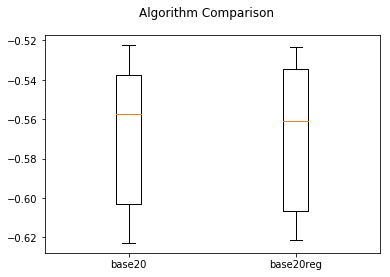

In [30]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot((results))
names = [i.__name__ for i in model]
ax.set_xticklabels(names)
plt.show()

In [32]:
df_sample_sub = pd.read_csv(data_dir + 'SampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [33]:
X_test = np.zeros(shape=(n_test_games, xDim))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = t1_seed
    X_test[ii, 1] = diff_seed
    X_test[ii, 2] = t1
    X_test[ii, 3] = year


### Scale data with appropriate scaler

In [34]:
X_test = scaler.fit_transform(X_test)

## Make Predictions ##
Create predictions using the logistic regression model we trained.

In [35]:
preds = base2.predict(X_test)

NameError: name 'base2' is not defined

In [ ]:
clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

Lastly, create your submission file!

In [ ]:
filename = 'KerasMLP_RankSeedsYear'
c=0
ext = '.csv'
if os.path.exists(filename+ext):
    while os.path.exists(filename+ext):
        c+=1
        filename = filename+'_'+str(c)
    df_sample_sub.to_csv(filename+ext, index=False)
else:
    df_sample_sub.to_csv(filename+ext, index=False)